## 1. Importing Libraries

In [3]:
import tensorflow as tf

from keras import optimizers, regularizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

## 2. Gathering Data

In [4]:
# defining paths of train, validation and test data
train_path = "data/train"
valid_path = "data/valid"
test_path = "data/test"

In [11]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32

# loading training data and rescaling it using ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

# loading validation data and rescaling it using ImageDataGenerator
valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

# loading test data and rescaling it using ImageDataGenerator
test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#### Showing some pictures from the database we just imported

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


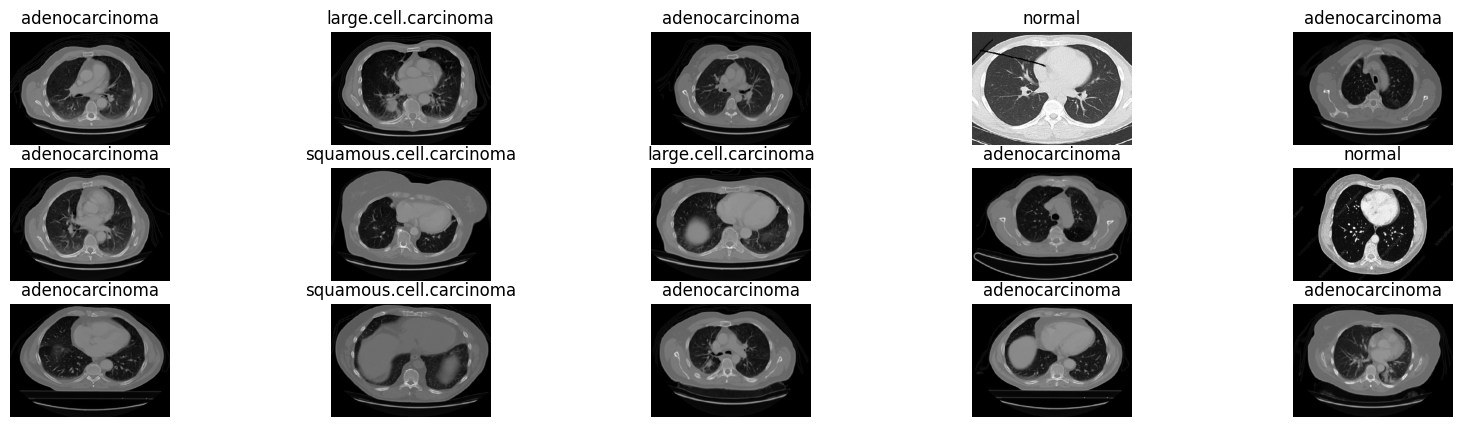

In [81]:
# extracting classes from our test data generator
class_names=list(test_generator.class_indices.keys())
print(class_names)

# creating a figure to plot the images on
fig = plt.figure(figsize=(20,5))

# plotting 15 images (3 rows and 5 cols) with their respective classes
image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])

## 3. Building the model

In [ ]:
# defining the coefficient that our regularizer will use
weight_decay = 1e-3

# building a sequential CNN model and adding layers to it
# dropout and the regularizer are used in general to prevent overfitting
first_model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')
])
# showing the summary of our model (layers and number of parameters)
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 305, 430, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 215, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 76, 107, 16)       0         
                                                                 
 flatten (Flatten)           (None, 130112)            0

## 4. Training the model

In [ ]:
# checkpointer to save the model only if it was improved
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
# early stopping to stop the training if our validation loss didn't decrease for (15) consecutive epochs
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
# Adam, best optimiser for deep learning models to help with the training
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
# setting our loss function and which metric to evaluate
first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])

# TRAIN
history = first_model.fit_generator(train_generator,
                    steps_per_epoch = 20,
                    epochs = 80,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

C:\Users\dell\AppData\Local\Temp\ipykernel_13944\1199349005.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = first_model.fit_generator(train_generator,


Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 1.4027 - acc: 0.3524
Epoch 1: val_loss improved from inf to 1.45218, saving model to chestmodel.hdf5
20/20 [==============================] - 33s 2s/step - loss: 1.4027 - acc: 0.3524 - val_loss: 1.4522 - val_acc: 0.3056
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 1.2284 - acc: 0.4356
Epoch 2: val_loss improved from 1.45218 to 1.33723, saving model to chestmodel.hdf5
20/20 [==============================] - 34s 2s/step - loss: 1.2284 - acc: 0.4356 - val_loss: 1.3372 - val_acc: 0.3056
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 1.1179 - acc: 0.5155
Epoch 3: val_loss improved from 1.33723 to 1.14852, saving model to chestmodel.hdf5
20/20 [==============================] - 32s 2s/step - loss: 1.1179 - acc: 0.5155 - val_loss: 1.1485 - val_acc: 0.5833
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 1.0759 - acc: 0.5269
Epoch 4: val_loss improved from 1.14852

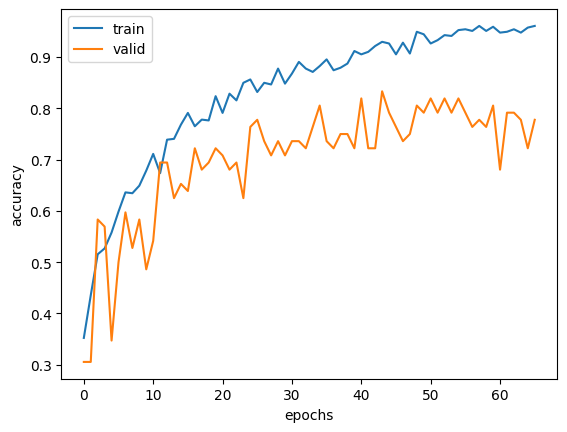

In [ ]:
# add history of accuracy and validation accuracy to the plot
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()

In [ ]:
# see if it's good at predecting new inputs
result = first_model.evaluate(test_generator)

10/10 [==============================] - 4s 402ms/step - loss: 1.3296 - acc: 0.5764


## 5. Transfer learning

#### **DenseNet201**

- Importing Data

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

# preprocess data to a predefined densenet inputs
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


- Downloading the densenet201 model

In [ ]:
# loading the densenet201 model without the last layer and with predefined weights
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers (last convolutional layer) not trainable
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

74836368/74836368 [==============================] - 8s 0us/step


- Building our model which includes densenet201

In [ ]:
# starting with densenet and adding layers to build our final model
densenet_model = Sequential()
densenet_model.add(dense_model)
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_6 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 1920)             7680      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18,337,348
Trainable params: 6,990,084
Non-trainable params: 11,347,264
_________________________________________________________________


- Hyperparameters setting and training

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 80,
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 1.2077 - acc: 0.4715 
Epoch 1: val_loss improved from inf to 1.32328, saving model to .\chestmodel-DenseNet201.hdf5
20/20 [==============================] - 406s 20s/step - loss: 1.2077 - acc: 0.4715 - val_loss: 1.3233 - val_acc: 0.4444
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 0.7304 - acc: 0.7423 
Epoch 2: val_loss improved from 1.32328 to 1.21350, saving model to .\chestmodel-DenseNet201.hdf5
20/20 [==============================] - 384s 19s/step - loss: 0.7304 - acc: 0.7423 - val_loss: 1.2135 - val_acc: 0.5139
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 0.5154 - acc: 0.8287 
Epoch 3: val_loss improved from 1.21350 to 1.12467, saving model to .\chestmodel-DenseNet201.hdf5
20/20 [==============================] - 391s 20s/step - loss: 0.5154 - acc: 0.8287 - val_loss: 1.1247 - val_acc: 0.5694
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 0.3831 - 

- Accuracy

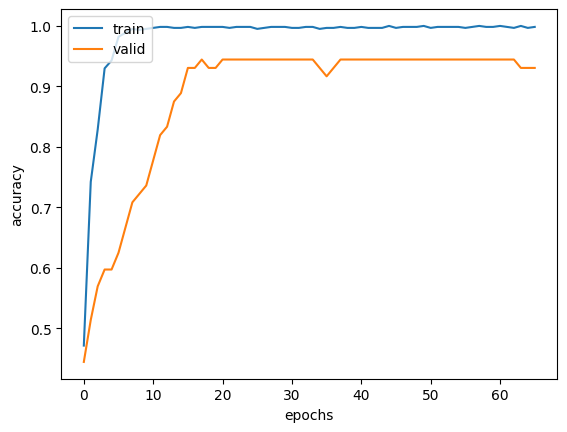

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
dns_result = densenet_model.evaluate(test_generator)

10/10 [==============================] - 128s 13s/step - loss: 0.4475 - acc: 0.8286


#### ResNet50

- Importing Data

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


- Downloading the resnet50 model

In [ ]:
# loading the resnet50 model without the last layer and with predefined weights
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers (last convolutional layer) not trainable
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

- Building our model which includes resnet50

In [ ]:
# starting with densenet and adding layers to build our final model
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Dropout(0.4))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(N_CLASSES, activation='softmax'))
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

- Hyperparameters setting and training

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
resnet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./finalmodel-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_res = resnet_model.fit(train_generator,
                            steps_per_epoch = 20,
                            epochs = 120,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])

Epoch 1/120
20/20 [==============================] - ETA: 0s - loss: 1.9844 - acc: 0.3116 
Epoch 1: val_loss improved from inf to 1.14999, saving model to .\finalmodel-ResNet50.hdf5
20/20 [==============================] - 238s 12s/step - loss: 1.9844 - acc: 0.3116 - val_loss: 1.1500 - val_acc: 0.5000
Epoch 2/120
20/20 [==============================] - ETA: 0s - loss: 1.3769 - acc: 0.4698 
Epoch 2: val_loss improved from 1.14999 to 1.03860, saving model to .\finalmodel-ResNet50.hdf5
20/20 [==============================] - 258s 13s/step - loss: 1.3769 - acc: 0.4698 - val_loss: 1.0386 - val_acc: 0.5278
Epoch 3/120
20/20 [==============================] - ETA: 0s - loss: 1.1116 - acc: 0.5498 
Epoch 3: val_loss improved from 1.03860 to 0.98371, saving model to .\finalmodel-ResNet50.hdf5
20/20 [==============================] - 250s 13s/step - loss: 1.1116 - acc: 0.5498 - val_loss: 0.9837 - val_acc: 0.5417
Epoch 4/120
20/20 [==============================] - ETA: 0s - loss: 0.9183 - acc: 

- Accuracy

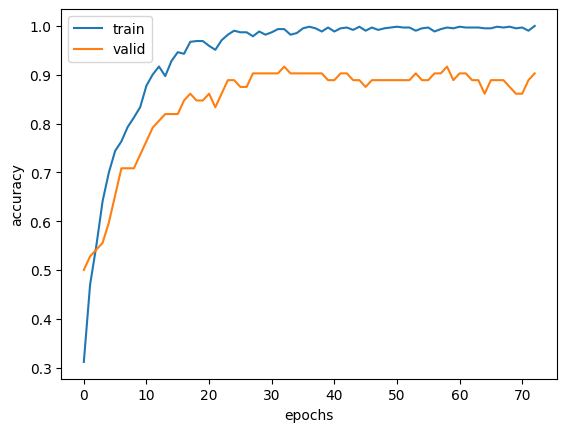

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = resnet_model.evaluate(test_generator)

10/10 [==============================] - 94s 9s/step - loss: 0.3730 - acc: 0.8730


## 6. Making predictions with best model (ResNet50)

In [ ]:
from keras.models import load_model
# load our saved model
resnet50_model = load_model('finalmodel-ResNet50.hdf5')

#### Confusion Matrix

In [ ]:
# defining paths for each class in the test folder
paths = ["data/test/adenocarcinoma/", "data/test/large.cell.carcinoma/", "data/test/normal/", "data/test/squamous.cell.carcinoma/"]
# initializing a dictionary to store predictions
results = {"adeno":{0:0, 1:0, 2:0, 3:0},
            "large":{0:0, 1:0, 2:0, 3:0},
            "normal":{0:0, 1:0, 2:0, 3:0},
            "squamous":{0:0, 1:0, 2:0, 3:0}}

# load images, predict and store predictions made by the model
for path, key in zip(paths, results.keys()):

    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(460, 460)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = resnet50_model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

{'adeno': {0: 99, 1: 5, 2: 0, 3: 16},
 'large': {0: 6, 1: 43, 2: 0, 3: 2},
 'normal': {0: 0, 1: 1, 2: 53, 3: 0},
 'squamous': {0: 7, 1: 3, 2: 0, 3: 80}}

In [ ]:
# convert the dictionary to a dataframe for better representation
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] + df["large"][1] + df["normal"][2] + df["squamous"][3]) / 315 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][1] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][2] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][3] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

Overall accuracy is : 87.30%

Adeno cancer detection accuracy is : 82.50%
Large cell cancer detection accuracy is : 84.31%
Normal chest detection accuracy is : 98.15%
Squamous cell cancer detection accuracy is : 88.89%

Confusion Matrix :


,0,1,2,3
adeno,99,5,0,16
large,6,43,0,2
normal,0,1,53,0
squamous,7,3,0,80


#### Predict for one picture

In [ ]:
# define the image's path
img_path = "data/test/squamous.cell.carcinoma/000111.png"

# get classes names
class_names=list(test_generator.class_indices.keys())

# preprocess the image so the model can treat it properly
img = tf.keras.utils.load_img(img_path, target_size=(460, 460))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# predict with our loaded model
prediction = resnet50_model.predict(img_array)

# result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)


1/1 [==============================] - 0s 397ms/step
This image most likely belongs to squamous.cell.carcinoma with a 98.31 percent confidence.
